In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from utils import Processor, EnsembleClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import telepot
%matplotlib inline

from sklearn import svm,cross_validation,tree,linear_model,preprocessing,metrics
from sklearn.mixture import GMM
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB

In [2]:
# os.chdir('/')
trainFid = 'KDDTrain+.txt'
testFid = 'KDDTest-21.txt'
bot = telepot.Bot('258510570:AAHujlmQqiZ_L4yrWMR9HtuE-0rK8xXo-XY')

## 資料前處理

In [3]:
traindata, attack_type_list = Processor.cleanData(trainFid)
traindata = traindata
test_data_len = 1000
traindata_len = len(traindata) - test_data_len
testdata = traindata[traindata_len - test_data_len:]
traindata = traindata[:traindata_len - test_data_len]
testdata, _ = Processor.cleanData(testFid)
traindata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


##### 列出一些基本資料

In [4]:
print "攻擊型態：%s" % attack_type_list
print "有%d筆訓練資料" % len(traindata)
print "有%d筆測試資料" % len(testdata)

攻擊型態：['normal', 'dos', 'r2l', 'probe', 'u2r']
有123973筆訓練資料
有11850筆測試資料


##### 資料的特徵及屬性

In [5]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123973 entries, 0 to 123972
Data columns (total 42 columns):
duration                       123973 non-null int64
protocol_type                  123973 non-null object
service                        123973 non-null object
flag                           123973 non-null object
src_bytes                      123973 non-null int64
dst_bytes                      123973 non-null int64
land                           123973 non-null int64
wrong_fragment                 123973 non-null int64
urgent                         123973 non-null int64
hot                            123973 non-null int64
num_failed_logins              123973 non-null int64
logged_in                      123973 non-null int64
num_compromised                123973 non-null int64
root_shell                     123973 non-null int64
su_attempted                   123973 non-null int64
num_root                       123973 non-null int64
num_file_creations             123973 

#### 1. 檢視攻擊種類分佈

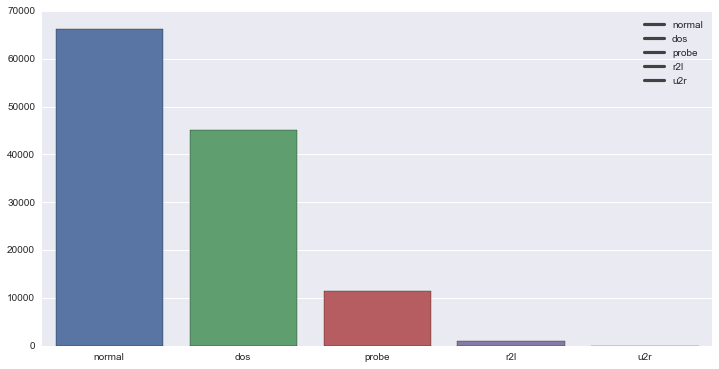

In [6]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x=range(0, len(traindata['attack_type'].value_counts())), y=traindata['attack_type'].value_counts().tolist())
attack_t = [attack_type_list[i] for i in traindata['attack_type'].value_counts().index]
plt.legend(attack_t,loc=0)
ax.set_xticklabels(attack_t)

#### 2. 資料標準化

In [7]:
data_all = pd.concat([traindata, testdata])
traindata_df = pd.get_dummies(
    Processor.normalize(data_all.drop(['attack_type'], axis=1)))[:len(traindata)]
testdata_df = pd.get_dummies(
    Processor.normalize(data_all.drop(['attack_type'], axis=1)))[len(traindata):]
traindata_df['attack_type'] = traindata['attack_type']
testdata_df['attack_type'] = testdata['attack_type']
anomalydata_df = traindata_df[traindata_df['attack_type']!=0]
anomalydata_df.index = range(0, len(anomalydata_df))
normaldata_df = traindata_df[traindata_df['attack_type']==0]
normaldata_df.index = range(0, len(normaldata_df))

In [8]:
normaldata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.116897,-0.007832,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.116897,-0.007914,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.116897,-0.007893,-0.002642,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,1.268526,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,-0.116897,-0.007901,-0.004639,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,1.268526,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,-0.116897,-0.007880,-0.004166,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,1.268526,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [9]:
anomalydata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.116897,-0.007948,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,-0.116897,-0.007948,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.116897,-0.007948,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.116897,-0.007948,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,-0.116897,-0.007948,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [10]:
testdata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,13,tcp,telnet,SF,118,2425,0,0,0,0,...,10,0.38,0.12,0.04,0.0,0.00,0.00,0.12,0.3,0
1,0,udp,private,SF,44,0,0,0,0,0,...,254,1.00,0.01,0.01,0.0,0.00,0.00,0.00,0.0,1
2,0,tcp,telnet,S3,0,44,0,0,0,0,...,79,0.31,0.61,0.00,0.0,0.21,0.68,0.60,0.0,1
3,0,udp,private,SF,53,55,0,0,0,0,...,255,1.00,0.00,0.87,0.0,0.00,0.00,0.00,0.0,2
4,0,tcp,private,SH,0,0,0,0,0,0,...,1,0.06,1.00,1.00,0.0,1.00,1.00,0.00,0.0,3


#### 3. 異常資料分群

In [11]:
K = 3
kmeans = KMeans(n_clusters=K, random_state=0).fit(anomalydata_df.iloc[:,:anomalydata_df.shape[1]-1])
clustors = kmeans.predict(anomalydata_df.iloc[:,:anomalydata_df.shape[1]-1])

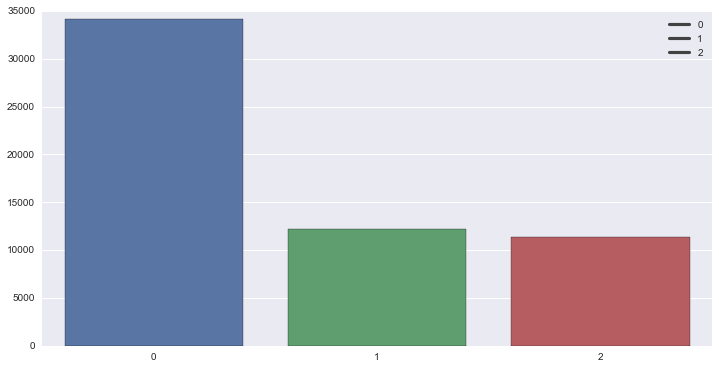

In [12]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x=range(0, len(pd.Series(clustors).value_counts())), y=pd.Series(clustors).value_counts().tolist())
plt.legend(pd.Series(clustors).value_counts().index.tolist(),loc=0)
ax.set_xticklabels(pd.Series(clustors).value_counts().index.tolist())

In [13]:
try:
    anomalydata_df = anomalydata_df.drop(['clusters'], axis = 1)
except:
    pass
anomalydata_df.insert(0, 'clusters', pd.Series(clustors, dtype=np.int64))

In [14]:
cluster_df = []
for cluster in sorted(anomalydata_df['clusters'].unique()):
    node = anomalydata_df[anomalydata_df['clusters']==cluster]
    node = node.drop(['clusters'], axis=1)
    cluster_df.append(node)

In [15]:
cluster_df[2]['attack_type'].value_counts().sort_index()

1    4631
2     933
3    5716
4      52
Name: attack_type, dtype: int64

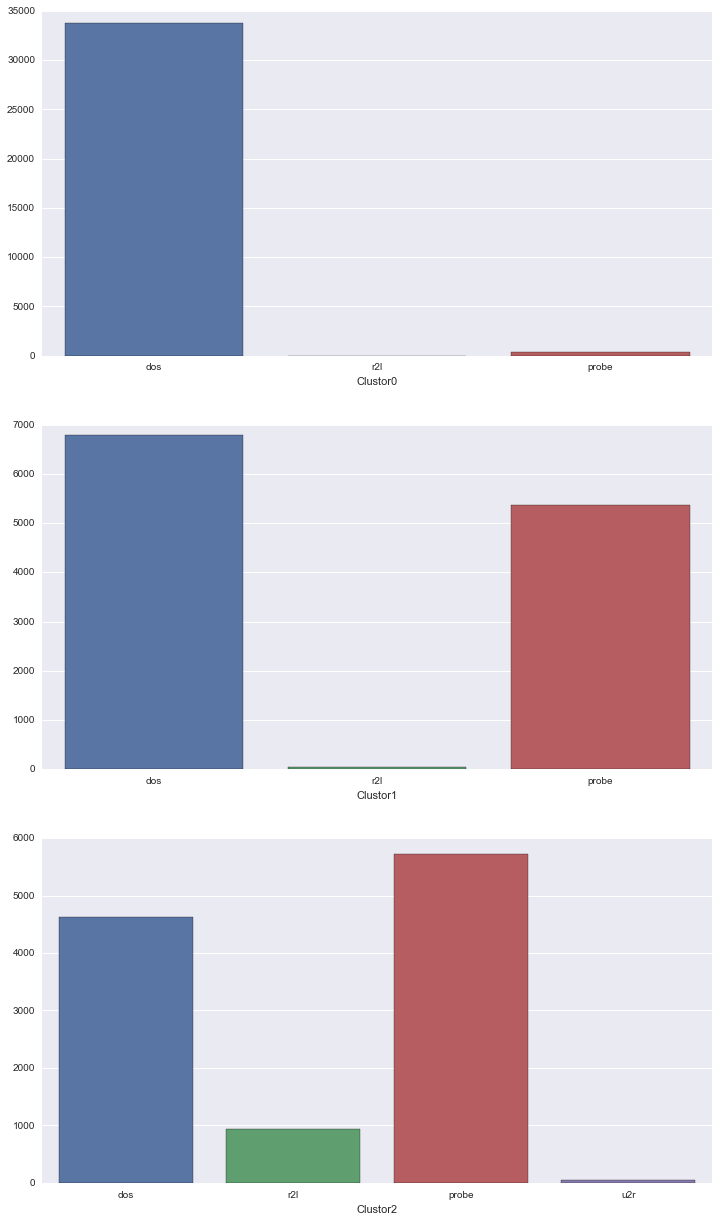

In [16]:
fig, ax = plt.subplots(len(cluster_df), 1, figsize = (12, len(cluster_df) * 7))
for index, cluster in enumerate(cluster_df):
    sns.barplot(x=range(0, len(cluster['attack_type'].value_counts()))\
                     , y=(cluster['attack_type'].value_counts().sort_index()).tolist()\
                     , ax = ax[index])
    attack_t = [attack_type_list[i] for i in cluster['attack_type'].value_counts().sort_index().index]
    ax[index].set_xticklabels(attack_t)
    ax[index].set_xlabel("Clustor%d" % index)

#### 4. 正常資料與異常合併

In [17]:
for index in range(0, len(cluster_df)):
    df = pd.concat([cluster_df[0], normaldata_df], ignore_index = True)
    cluster_df[index] = pd.concat([cluster_df[index], normaldata_df], ignore_index = True)
    cluster_df[index] = cluster_df[index].iloc[np.random.permutation(len(cluster_df[index]))]
    cluster_df[index].index = range(0, len(cluster_df[index]))

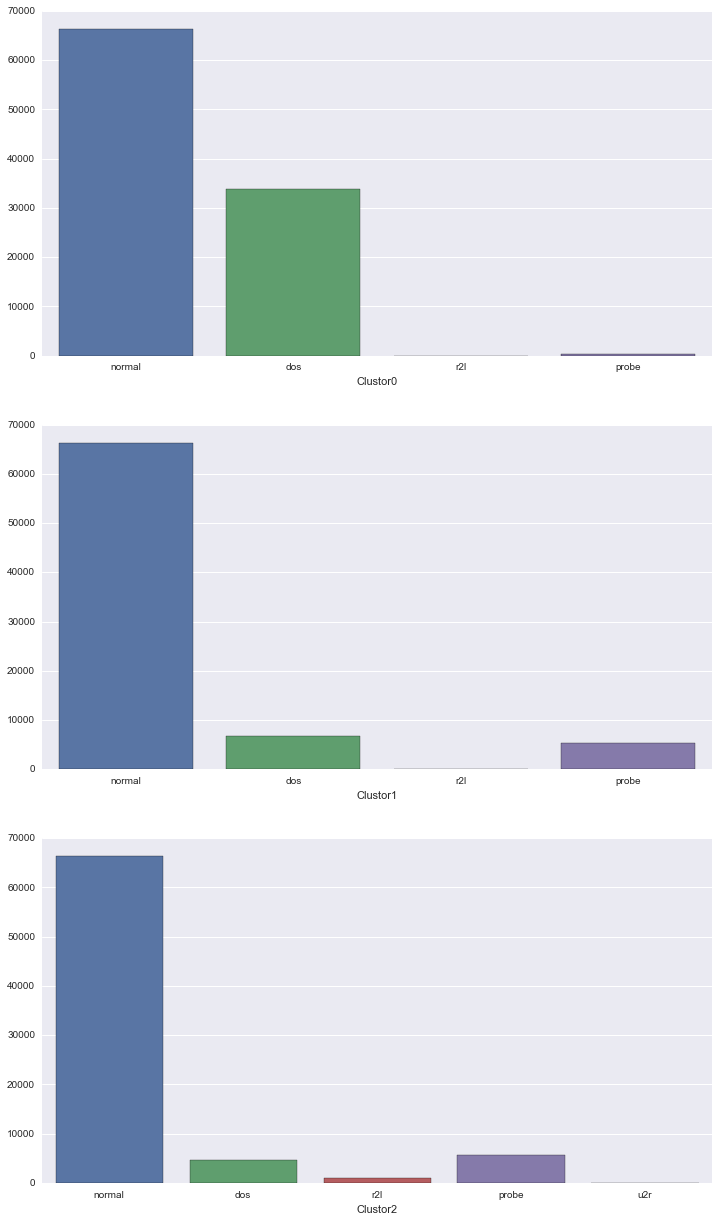

In [18]:
fig, ax = plt.subplots(len(cluster_df), 1, figsize = (12, len(cluster_df) * 7))
for index, cluster in enumerate(cluster_df):
    sns.barplot(x=range(0, len(cluster['attack_type'].value_counts().sort_index()))\
                     , y=(cluster['attack_type'].value_counts().sort_index()).tolist()\
                     , ax = ax[index])
    attack_t = [attack_type_list[i] for i in cluster['attack_type'].value_counts().sort_index().index]
    ax[index].set_xticklabels(attack_t)
    ax[index].set_xlabel("Clustor%d" % index)

## 針對資料進行學習

#### 1. 最簡單的分類器

In [19]:
traindata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.116897,-0.007832,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.116897,-0.007914,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.116897,-0.007948,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.116897,-0.007893,-0.002642,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,1.268526,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,-0.116897,-0.007901,-0.004639,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,1.268526,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [20]:
testdata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.111778,-0.007920,-0.004121,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,1.268526,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.116897,-0.007938,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,-0.116897,-0.007948,-0.004736,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,-0.116897,-0.007936,-0.004733,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
4,-0.116897,-0.007948,-0.004747,-0.015351,-0.088898,-0.010878,-0.09731,-0.062403,-0.788311,-0.011876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3


###### 新增一個對照組 (利用決策樹)

In [29]:
train_x = traindata_df.drop(['attack_type'], axis = 1).values
train_y = traindata_df['attack_type'].values
test_x = testdata_df.drop(['attack_type'], axis = 1).values
answer = testdata_df['attack_type'].values
answer = np.array([0 if a == 0 else 1 for a in answer])
tree = LogisticRegression()
tree.fit(train_x, train_y)
predict = tree.predict(test_x)
predict = np.array([0 if p == 0 else 1 for p in predict])
print "準確度：%f" % (float(len(np.where(answer == predict)[0])) / len(test_x))
print("混淆矩陣:\n%s"
    % metrics.confusion_matrix(answer, predict))

準確度：0.633755
混淆矩陣:
[[2165   34]
 [4306 5345]]


###### 分層訓練

In [22]:
en_clf_list = []
for index in range(0, len(cluster_df)):
    clf_cluster = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        GaussianNB(),
        AdaBoostClassifier()
    ]
    
    train_y = cluster_df[index]['attack_type'].values
    train_x = cluster_df[index].drop(['attack_type'], axis = 1).values
    
    en = EnsembleClassifier(clf_cluster)
    en.fit(train_x, train_y)
    en_clf_list.append(en)

###### 分層預測

In [23]:
test_x = testdata_df.drop(['attack_type'], axis = 1).values
answer = testdata_df['attack_type'].values
prediction = []
normal_index = []

for index in range(0, len(en_clf_list)):
    predict = en_clf_list[index].predict(test_x)
    normal_index.append(np.where(predict == attack_type_list.index('normal'))[0])
    
    test_x = test_x[normal_index[index]]
    answer = answer[normal_index[index]]

In [24]:
answer = testdata_df['attack_type'].values
pre = normal_index[0][normal_index[1][normal_index[2]]]
predict = []
for i in range(0, len(answer)):
    if i in pre:
        predict.append(attack_type_list.index('normal'))
    else:
        predict.append(1)
predict = np.array(predict)
answer = np.array([0 if a == 0 else 1 for a in answer])

##### 經過多層次分類器預測後的準確機率

In [25]:
# 預測準確的資料長度 / 測試資料的長度
print float(len(np.where(np.array(predict) == np.array(answer))[0])) / len(answer)

0.538565400844


In [26]:
# 混淆矩陣
print("Confusion matrix:\n%s"
    % metrics.confusion_matrix(answer, predict))

Confusion matrix:
[[2089  110]
 [5358 4293]]


In [27]:
bot.sendMessage('252175743', '多層次分類器運算完了')

{u'chat': {u'first_name': u'\u9673',
  u'id': 252175743,
  u'last_name': u'\u9347\u5609',
  u'type': u'private',
  u'username': u'kaijia'},
 u'date': 1479021336,
 u'from': {u'first_name': u'kaijiabot',
  u'id': 258510570,
  u'username': u'kaijia_bot'},
 u'message_id': 19,
 u'text': u'\u591a\u5c64\u6b21\u5206\u985e\u5668\u904b\u7b97\u5b8c\u4e86'}